# Modeling complex time series

![Sample Image](/Users/maukanmir/Documents/Machine-Learning/AI-ML-Textbooks/AI-ML-Learning/images/ARMA-process.png)


## Examining the autoregressive moving average process
#### The autoregressive moving average process is a combination of the autoregressive process and the moving average process. It states that the present value is linearly dependent on its own previous values and a constant, just like in an autoregressive process, as well as on the mean of the series, the current error term, and past error terms, like in a moving average process

#### The autoregressive moving average process is denoted as ARMA(p,q), where p is the order of the autoregressive portion, and q is the order of the moving average portion. Mathematically, the ARMA(p,q) process is expressed as a linear combination of a constant C, the past values of the series yt–p, the mean of the series µ, past error terms ϵt–q, and the current error term ϵt, as shown in equation 6.1.

- yt = C + ϕ1yt–1 + ϕ2yt–2 +⋅⋅⋅+ ϕpyt–p + ϵt + θ1ϵt–1 + θ2ϵt–2 +⋅⋅⋅+ θqϵt–q

In [1]:
from statsmodels.tsa.arima_process import ArmaProcess
import numpy as np
 
np.random.seed(42)
 
ar1 = np.array([1, -0.33])
ma1 = np.array([1, 0.9])
 
ARMA_1_1 = ArmaProcess(ar1, ma1).generate_sample(nsample=1000) 

In [2]:
from statsmodels.tsa.stattools import adfuller
 
ADF_result = adfuller(ARMA_1_1)
 
print(f'ADF Statistic: {ADF_result[0]}')
print(f'p-value: {ADF_result[1]}')

ADF Statistic: -6.429878682042679
p-value: 1.7078466680097946e-08


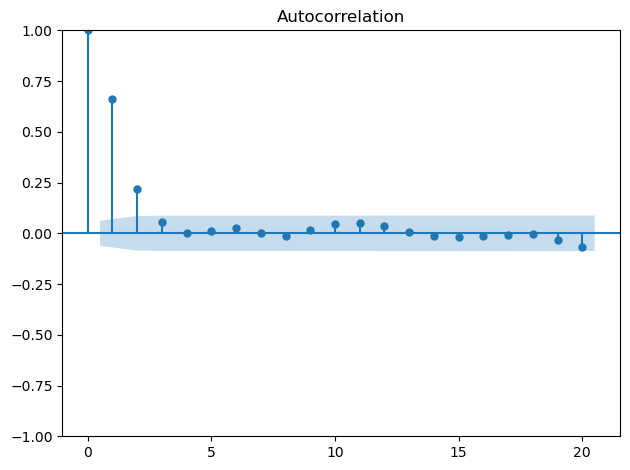

In [3]:
from matplotlib import pyplot as plt
from statsmodels.graphics.tsaplots import plot_acf

plot_acf(ARMA_1_1, lags=20);
 
plt.tight_layout()

#### In figure 6.4 you’ll notice a sinusoidal pattern in the plot, which indicates the presence of an autoregressive process. This is expected, since we simulated an ARMA(1,1) process and we know of the existence of the autoregressive portion. Furthermore, you’ll notice that the last significant coefficient is at lag 2. However, we know that our simulated data has an MA(1) process, so we would expect to have significant coefficients up to lag 1 only. We can thus conclude that the ACF plot does not reveal any useful information about the order q of our ARMA(1,1) process.

#### We can now move on to the next step outlined in figure 6.3 and plot the PACF. In chapter 5 you learned that the PACF can be used to find the order of a stationary AR(p) process. We will now verify whether we can find the order p of our simulated ARMA(1,1) process, where p = 1. We’ll use the plot_pacf function to generate figure 6.5.

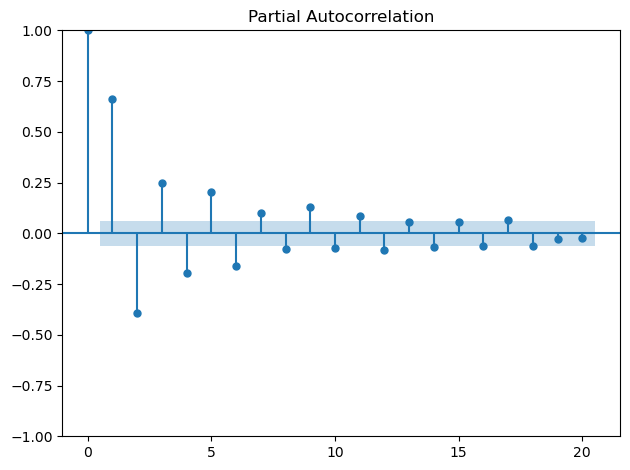

In [4]:
from statsmodels.graphics.tsaplots import plot_pacf
 
plot_pacf(ARMA_1_1, lags=20);
 
plt.tight_layout()


#### In figure 6.5 we can see a clear sinusoidal pattern, meaning that we cannot infer a value for the order p. We know that we simulated an ARMA(1,1) process, but we cannot determine that value from the PACF plot in figure 6.5, since we have significant coefficients past lag 1. Therefore, the PACF plot cannot be used to find the order p of an ARMA(p,q) process.

#### If your process is stationary and both the ACF and PACF plots show a decaying or sinusoidal pattern, then it is a stationary ARMA(p,q) process.

![Sample Image](/Users/maukanmir/Documents/Machine-Learning/AI-ML-Textbooks/AI-ML-Learning/images/residual-analysis.png)

#### In figure 6.6 you can see that this new modeling procedure completely removes the plotting of the ACF and PACF. It allows us to select a model based entirely on statistical tests and numerical criteria, instead of relying on the qualitative analysis of the ACF and PACF plots.

#### Therefore, the residuals must be uncorrelated and independently distributed. We can assess those properties by studying the quantile-quantile plot (Q-Q plot) and running the Ljung-Box test, which we’ll explore in section 6.4.3. If the analysis leads us to conclude that the residuals are completely random, we have a model ready for forecasting. Otherwise, we must try a different set of values for p and q and start the process over.

## Understanding the Akaike information criterion (AIC)

#### Before covering the steps outlined in figure 6.6, we need to determine how we will choose the best model of all the models that we will fit. Here we will use the Akaike information criterion (AIC) to select the optimal model.

#### The AIC estimates the quality of a model relative to other models. Given that there will be some information lost when a model is fitted to the data, the AIC quantifies the relative amount of information lost by the model. The less information lost, the lower the AIC value and the better the model.

#### The AIC is a function of the number of estimated parameters k and the maximum value of the likelihood function for the model L̂, as shown in equation 6.8.

- AIC 2k – 2ln(L̂)
- The lower the value of the AIC, the better the model. Selecting according to the AIC allows us to keep a balance between the complexity of a model and its goodness of fit to the data.

In [5]:
from itertools import product
 
ps = range(0, 4, 1)
qs = range(0, 4, 1)
 
order_list = list(product(ps, qs))

In [6]:
from sklearn.metrics import mean_squared_error, mean_absolute_error
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
from statsmodels.tsa.statespace.sarimax import SARIMAX
from statsmodels.tsa.arima_process import ArmaProcess
from statsmodels.tsa.stattools import adfuller
from tqdm import tqdm_notebook
from itertools import product
from typing import Union
import pandas as pd

def optimize_ARMA(endog: Union[pd.Series, list], order_list: list) -> pd.DataFrame:
    
    results = []
    
    for order in tqdm_notebook(order_list):
        try: 
            model = SARIMAX(endog, order=(order[0], 0, order[1]), simple_differencing=False).fit(disp=False)
        except:
            continue
            
        aic = model.aic
        results.append([order, aic])
        
    result_df = pd.DataFrame(results)
    result_df.columns = ['(p,q)', 'AIC']
    
    #Sort in ascending order, lower AIC is better
    result_df = result_df.sort_values(by='AIC', ascending=True).reset_index(drop=True)
    
    return result_df

In [7]:
result_df = optimize_ARMA(ARMA_1_1, order_list)
result_df   

/var/folders/bb/2qsf8cm95jg05zrms2_8m2qr0000gn/T/ipykernel_64086/2721766129.py:15: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`
  for order in tqdm_notebook(order_list):


  0%|          | 0/16 [00:00<?, ?it/s]

/Users/maukanmir/miniforge3/envs/machine-learning-env/lib/python3.9/site-packages/statsmodels/tsa/statespace/sarimax.py:978: UserWarning: Non-invertible starting MA parameters found. Using zeros as starting parameters.
  warn('Non-invertible starting MA parameters found.'
/Users/maukanmir/miniforge3/envs/machine-learning-env/lib/python3.9/site-packages/statsmodels/tsa/statespace/sarimax.py:966: UserWarning: Non-stationary starting autoregressive parameters found. Using zeros as starting parameters.
  warn('Non-stationary starting autoregressive parameters'
/Users/maukanmir/miniforge3/envs/machine-learning-env/lib/python3.9/site-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


,"(p,q)",AIC
0,"(1, 1)",2801.407785
1,"(2, 1)",2802.906070
2,"(1, 2)",2802.967762
3,"(0, 3)",2803.666793
4,"(1, 3)",2804.524027
5,"(3, 1)",2804.588567
6,"(2, 2)",2804.822282
7,"(3, 3)",2806.128015
8,"(2, 3)",2806.175380
9,"(3, 2)",2806.894930


## Understanding residual analysis

#### Up to this point, we have fit different ARMA(p,q) models to our simulated ARMA(1,1) process. Using the AIC as a model selection criterion, we found that an ARMA(1,1) model is the best model relative to all others that were fit. Now we must measure its absolute quality by performing an analysis on the model’s residuals.

#### The first step in residual analysis is the study of the quantile-quantile plot (Q-Q plot). The Q-Q plot is a graphical tool for verifying our hypothesis that the model’s residuals are normally distributed.

#### The Q-Q plot is constructed by plotting the quantiles of our residuals on the y-axis against the quantiles of a theoretical distribution, in this case the normal distribution, on the x-axis. This results in a scatterplot. We are comparing the distribution to a normal distribution because we want the residuals to be similar to white noise, which is normally distributed.

#### A Q-Q plot is a plot of the quantiles of two distributions against each other. In time series forecasting, we plot the distribution of our residuals on the y-axis against the theoretical normal distribution on the x-axis.

#### This graphical tool allows to us to assess the goodness of fit of our model. If the distribution of our residuals is similar to a normal distribution, we will see a straight line lying on y = x. This means that our model is a good fit, because the residuals are similar to white noise.

#### On the other hand, if the distribution of our residuals is different from a normal distribution, we will see a curved line. We can then conclude that our model is not a good fit, since the residuals’ distribution is not close to a normal distribution, and therefore the residuals are not similar to white noise.

#### The Ljung-Box test is a statistical test that tests if the autocorrelation of a group of data is significantly different from 0. In our case, we will apply the Ljung-Box test to the model’s residuals to assess whether they are correlated or not. The null hypothesis states that the data is independently distributed, meaning that there is no autocorrelation.

- The Ljung-Box test is a statistical test that determines whether the autocorrelation of a group of data is significantly different from 0.

#### In time series forecasting, we apply the Ljung-Box test on the model’s residuals to test whether they are similar to white noise. The null hypothesis states that the data is independently distributed, meaning that there is no autocorrelation. If the p-value is larger than 0.05, we cannot reject the null hypothesis, meaning that the residuals are independently distributed. Therefore, there is no autocorrelation, the residuals are similar to white noise, and the model can be used for forecasting.

In [8]:
model = SARIMAX(ARMA_1_1, order=(1,0,1), simple_differencing=False)
model_fit = model.fit(disp=False)
residuals = model_fit.resid 

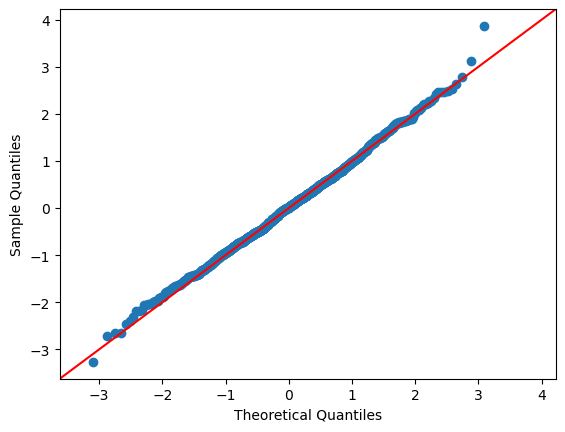

In [9]:
from statsmodels.graphics.gofplots import qqplot
 
qqplot(residuals, line='45'); 

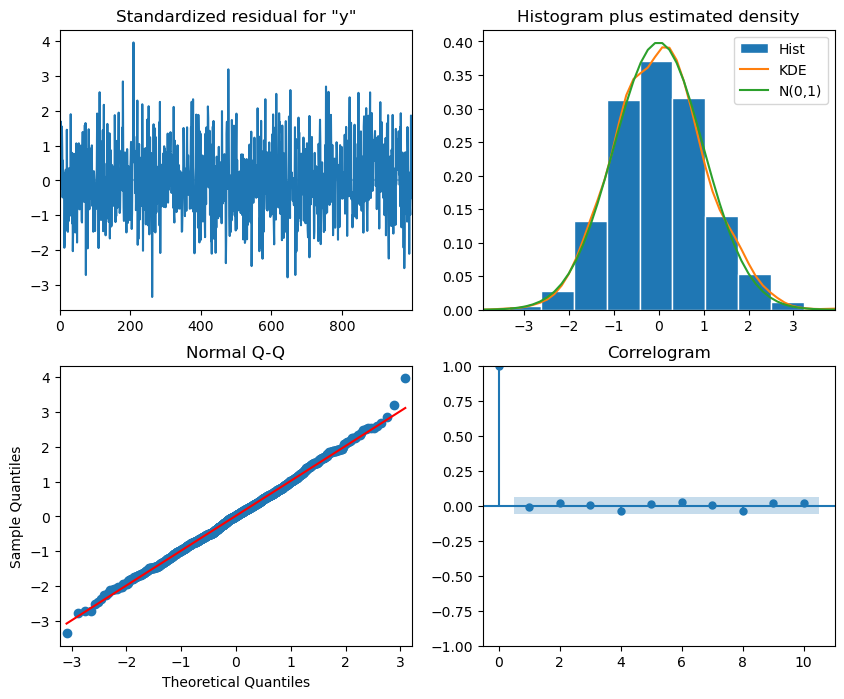

In [10]:
model_fit.plot_diagnostics(figsize=(10, 8));

In [15]:
from statsmodels.stats.diagnostic import acorr_ljungbox

lbvalue, pvalue = acorr_ljungbox(residuals, np.arange(1, 11, 1))

print(pvalue)

lb_pvalue


In [16]:
df = pd.read_csv("/Users/maukanmir/Documents/Machine-Learning/AI-ML-Textbooks/AI-ML-Learning/Data/bandwith.csv")
df

,hourly_bandwidth
0,1000.496714
1,1000.969408
2,1002.046019
3,1004.702118
4,1007.447816
...,...
9995,740.546059
9996,738.906228
9997,736.057995
9998,733.559640


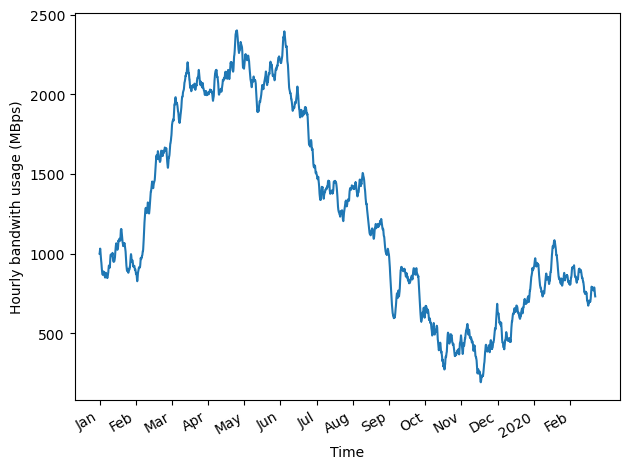

In [17]:
import matplotlib.pyplot as plt
 
fig, ax = plt.subplots()
 
ax.plot(df.hourly_bandwidth)
ax.set_xlabel('Time')
ax.set_ylabel('Hourly bandwith usage (MBps)')
 
plt.xticks(
    np.arange(0, 10000, 730), 
    ['Jan', 'Feb', 'Mar', 'Apr', 'May', 'Jun', 'Jul', 'Aug', 'Sep', 'Oct', 
'Nov', 'Dec', '2020', 'Feb'])
 
fig.autofmt_xdate()
plt.tight_layout()

In [18]:
from statsmodels.tsa.stattools import adfuller
 
ADF_result = adfuller(df['hourly_bandwidth'])
 
print(f'ADF Statistic: {ADF_result[0]}')
print(f'p-value: {ADF_result[1]}')

ADF Statistic: -0.8714653199453102
p-value: 0.7972240255014433


In [19]:
import numpy as np
 
bandwidth_diff = np.diff(df.hourly_bandwidth, n=1)

In [20]:
ADF_result = adfuller(bandwidth_diff)
 
print(f'ADF Statistic: {ADF_result[0]}')
print(f'p-value: {ADF_result[1]}')

ADF Statistic: -20.69485386378903
p-value: 0.0


In [21]:
df_diff = pd.DataFrame({'bandwidth_diff': bandwidth_diff})
 
train = df_diff[:-168]
test = df_diff[-168:]
 
print(len(train))
print(len(test))

9831
168


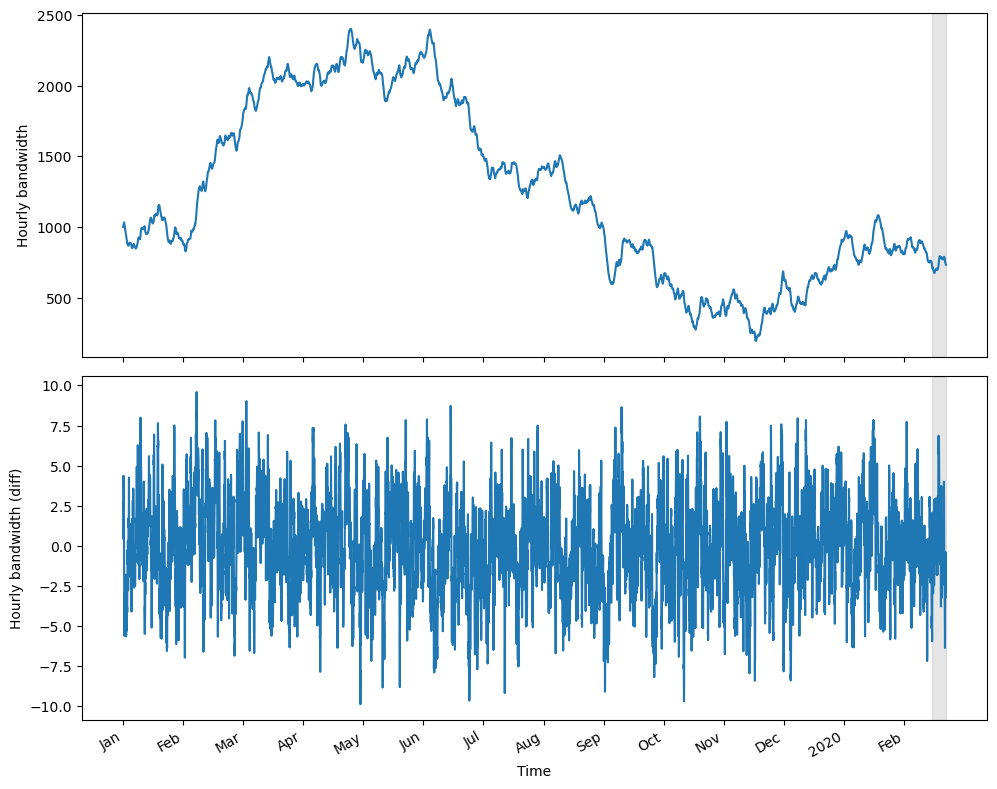

In [22]:
fig, (ax1, ax2) = plt.subplots(nrows=2, ncols=1, sharex=True, figsize=(10, 8))
 
ax1.plot(df.hourly_bandwidth)
ax1.set_xlabel('Time')
ax1.set_ylabel('Hourly bandwidth')
ax1.axvspan(9831, 10000, color='#808080', alpha=0.2)
 
ax2.plot(df_diff.bandwidth_diff)
ax2.set_xlabel('Time')
ax2.set_ylabel('Hourly bandwidth (diff)')
ax2.axvspan(9830, 9999, color='#808080', alpha=0.2)
 
plt.xticks(
    np.arange(0, 10000, 730), 
    ['Jan', 'Feb', 'Mar', 'Apr', 'May', 'Jun', 'Jul', 'Aug', 'Sep', 'Oct', 'Nov', 'Dec', '2020', 'Feb'])
 
fig.autofmt_xdate()
plt.tight_layout()

- p (AR order): This is the number of lag observations included in the model, or the lag order. It represents the number of past data points that the model considers to predict the current value in a time series.

- q (MA order): This is the order of the moving average part. It represents the number of lagged forecast errors that the model uses to predict the current value.

In [23]:
from typing import Union

def optimize_ARMA(endog: Union[pd.Series, list], order_list: list) -> pd.DataFrame:
    
    results = []
    
    for order in tqdm_notebook(order_list):
        try: 
            model = SARIMAX(endog, order=(order[0], 0, order[1]), simple_differencing=False).fit(disp=False)
        except:
            continue
            
        aic = model.aic
        results.append([order, aic])
        
    result_df = pd.DataFrame(results)
    result_df.columns = ['(p,q)', 'AIC']
    
    #Sort in ascending order, lower AIC is better
    result_df = result_df.sort_values(by='AIC', ascending=True).reset_index(drop=True)
    
    return result_df

In [25]:
ps = range(0, 4, 1)
qs = range(0, 4, 1)

order_list = list(product(ps, qs))

In [26]:
result_df = optimize_ARMA(train['bandwidth_diff'], order_list)
result_df

/var/folders/bb/2qsf8cm95jg05zrms2_8m2qr0000gn/T/ipykernel_64086/3649428702.py:7: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`
  for order in tqdm_notebook(order_list):


  0%|          | 0/16 [00:00<?, ?it/s]

/Users/maukanmir/miniforge3/envs/machine-learning-env/lib/python3.9/site-packages/statsmodels/tsa/statespace/sarimax.py:978: UserWarning: Non-invertible starting MA parameters found. Using zeros as starting parameters.
  warn('Non-invertible starting MA parameters found.'
/Users/maukanmir/miniforge3/envs/machine-learning-env/lib/python3.9/site-packages/statsmodels/tsa/statespace/sarimax.py:978: UserWarning: Non-invertible starting MA parameters found. Using zeros as starting parameters.
  warn('Non-invertible starting MA parameters found.'
/Users/maukanmir/miniforge3/envs/machine-learning-env/lib/python3.9/site-packages/statsmodels/tsa/statespace/sarimax.py:978: UserWarning: Non-invertible starting MA parameters found. Using zeros as starting parameters.
  warn('Non-invertible starting MA parameters found.'


,"(p,q)",AIC
0,"(3, 2)",27991.063879
1,"(2, 3)",27991.287509
2,"(2, 2)",27991.603598
3,"(3, 3)",27993.416924
4,"(1, 3)",28003.349550
5,"(1, 2)",28051.351401
6,"(3, 1)",28071.155496
7,"(3, 0)",28095.618186
8,"(2, 1)",28097.250766
9,"(2, 0)",28098.407664


In [27]:
model = SARIMAX(train['bandwidth_diff'], order=(2,0,2), simple_differencing=False)
model_fit = model.fit(disp=False)
print(model_fit.summary())

                               SARIMAX Results                                
Dep. Variable:         bandwidth_diff   No. Observations:                 9831
Model:               SARIMAX(2, 0, 2)   Log Likelihood              -13990.802
Date:                Fri, 19 Jul 2024   AIC                          27991.604
Time:                        09:57:56   BIC                          28027.570
Sample:                             0   HQIC                         28003.788
                               - 9831                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1          0.3486      0.052      6.765      0.000       0.248       0.450
ar.L2          0.4743      0.047     10.000      0.000       0.381       0.567
ma.L1          0.8667      0.050     17.249      0.0

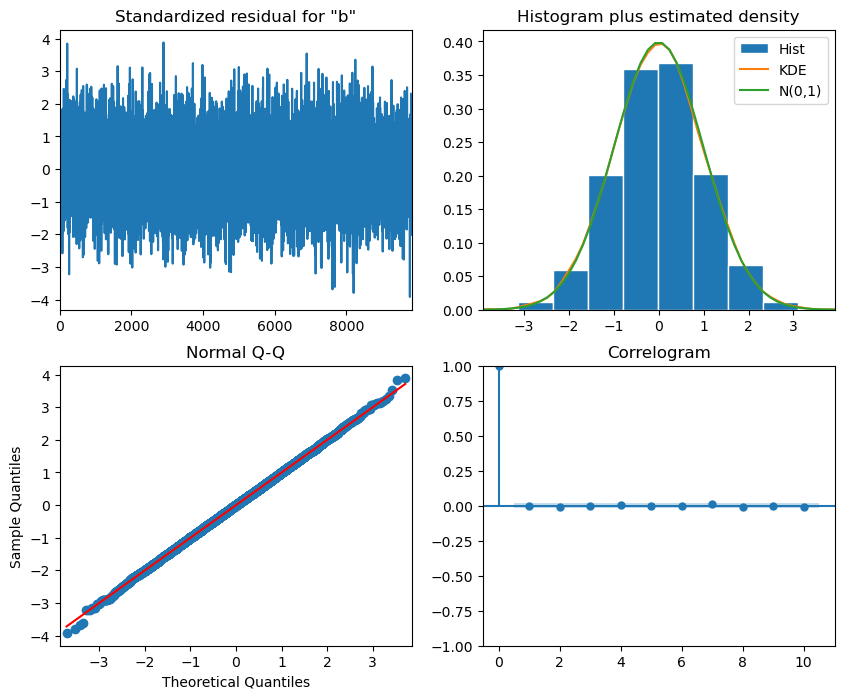

In [29]:
model_fit.plot_diagnostics(figsize=(10, 8));

#### In figure 6.18 you can see that the top-left plot shows no trend, and the mean seems constant over time, meaning that our residuals are likely stationary. The top right displays a density plot with a shape similar to that of a normal distribution. The Q-Q plot at the bottom left shows a thick straight line that is very close to y = x. Finally, the ACF plot at the bottom right shows no autocorrelation after lag 0. Thus, figure 6.18 indicates that our residuals clearly resemble white noise, since they are normally distributed and uncorrelated.

#### Our last step is to run the Ljung-Box test on the residuals for the first 10 lags. If the returned p-values exceed 0.05, we cannot reject the null hypothesis, which means that our residuals are uncorrelated and independently distributed, just like white noise.

In [31]:
residuals = model_fit.resid

lbvalue, pvalue = acorr_ljungbox(residuals, np.arange(1, 11, 1))

print(pvalue)

lb_pvalue


In [34]:
def rolling_forecast(df: pd.DataFrame, train_len: int, horizon: int, window: int, method: str) -> list:
    
    total_len = train_len + horizon
    end_idx = train_len
    
    if method == 'mean':
        pred_mean = []
        
        for i in range(train_len, total_len, window):
            mean = np.mean(df[:i].values)
            pred_mean.extend(mean for _ in range(window))
            
        return pred_mean

    elif method == 'last':
        pred_last_value = []
        
        for i in range(train_len, total_len, window):
            last_value = df[:i].iloc[-1].values[0]
            pred_last_value.extend(last_value for _ in range(window))
            
        return pred_last_value
    
    elif method == 'ARMA':
        pred_ARMA = []
        
        for i in range(train_len, total_len, window):
            model = SARIMAX(df[:i], order=(2,0,2))
            res = model.fit(disp=False)
            predictions = res.get_prediction(0, i + window - 1)
            oos_pred = predictions.predicted_mean.iloc[-window:]
            pred_ARMA.extend(oos_pred)
            
        return pred_ARMA

In [35]:
pred_df = test.copy()
 
TRAIN_LEN = len(train)
HORIZON = len(test)
WINDOW = 2
 
pred_mean = rolling_forecast(df_diff, TRAIN_LEN, HORIZON, WINDOW, 'mean')
pred_last_value = rolling_forecast(df_diff, TRAIN_LEN, HORIZON, WINDOW,  'last')
pred_ARMA = rolling_forecast(df_diff, TRAIN_LEN, HORIZON, WINDOW, 'ARMA')
 
test.loc[:, 'pred_mean'] = pred_mean
test.loc[:, 'pred_last_value'] = pred_last_value
test.loc[:, 'pred_ARMA'] = pred_ARMA
 
pred_df.head()

/var/folders/bb/2qsf8cm95jg05zrms2_8m2qr0000gn/T/ipykernel_64086/1440671749.py:11: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  test.loc[:, 'pred_mean'] = pred_mean
/var/folders/bb/2qsf8cm95jg05zrms2_8m2qr0000gn/T/ipykernel_64086/1440671749.py:12: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  test.loc[:, 'pred_last_value'] = pred_last_value
/var/folders/bb/2qsf8cm95jg05zrms2_8m2qr0000gn/T/ipykernel_64086/1440671749.py:13: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a Data

,bandwidth_diff
9831,-5.943995
9832,-5.865194
9833,-3.197066
9834,-1.090197
9835,0.665291


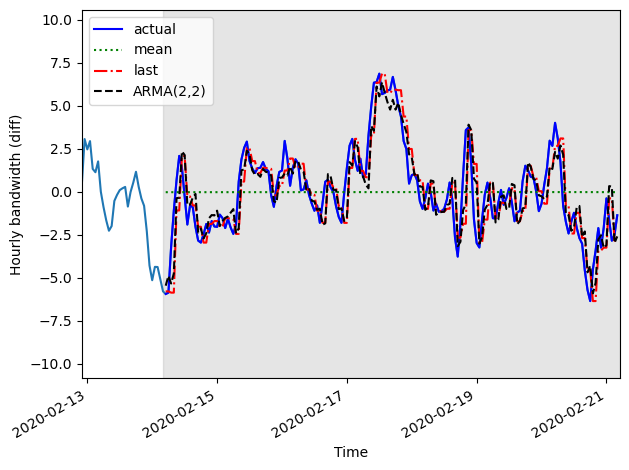

In [36]:
fig, ax = plt.subplots()
 
ax.plot(df_diff['bandwidth_diff'])
ax.plot(test['bandwidth_diff'], 'b-', label='actual')
ax.plot(test['pred_mean'], 'g:', label='mean')
ax.plot(test['pred_last_value'], 'r-.', label='last')
ax.plot(test['pred_ARMA'], 'k--', label='ARMA(2,2)')
ax.legend(loc=2)
ax.set_xlabel('Time')
ax.set_ylabel('Hourly bandwidth (diff)')
 
ax.axvspan(9830, 9999, color='#808080', alpha=0.2)
 
ax.set_xlim(9800, 9999)
 
plt.xticks(
    [9802, 9850, 9898, 9946, 9994],
    ['2020-02-13', '2020-02-15', '2020-02-17', '2020-02-19', '2020-02-21'])
 
fig.autofmt_xdate()
plt.tight_layout()

In [37]:
mse_mean = mean_squared_error(test['bandwidth_diff'], test['pred_mean'])
mse_last = mean_squared_error(test['bandwidth_diff'], test['pred_last_value'])
mse_ARMA = mean_squared_error(test['bandwidth_diff'], test['pred_ARMA'])
 
print(mse_mean, mse_last, mse_ARMA) 

6.306526957989325 2.2297582947733656 1.7690462115321086


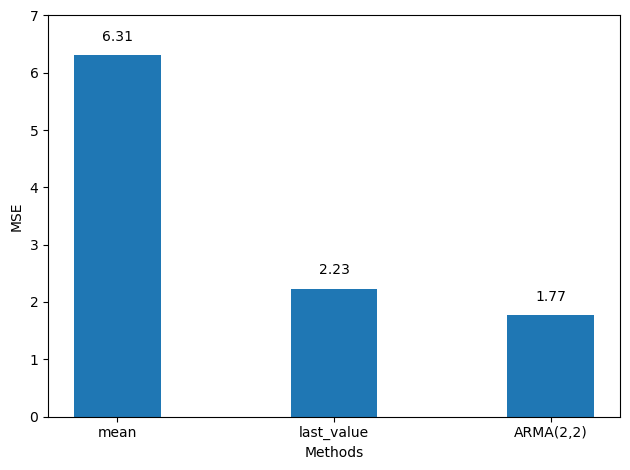

In [39]:
fig, ax = plt.subplots()

x = ['mean', 'last_value', 'ARMA(2,2)']
y = [mse_mean, mse_last, mse_ARMA] 

ax.bar(x, y, width=0.4)
ax.set_xlabel('Methods')
ax.set_ylabel('MSE')
ax.set_ylim(0, 7)

for index, value in enumerate(y):
    plt.text(x=index, y=value+0.25, s=str(round(value, 2)), ha='center')

plt.tight_layout()

In [40]:

df['pred_bandwidth'] = pd.Series()
df['pred_bandwidth'][9832:] = df['hourly_bandwidth'].iloc[9832] + test['pred_ARMA'].cumsum()

/var/folders/bb/2qsf8cm95jg05zrms2_8m2qr0000gn/T/ipykernel_64086/973870339.py:1: FutureWarning: The default dtype for empty Series will be 'object' instead of 'float64' in a future version. Specify a dtype explicitly to silence this warning.
  df['pred_bandwidth'] = pd.Series()


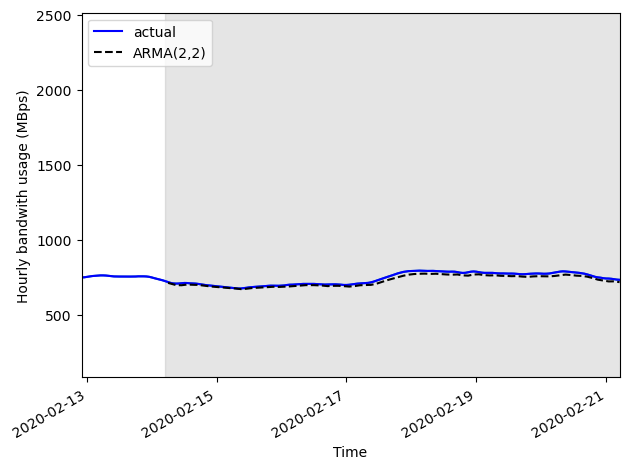

In [41]:
fig, ax = plt.subplots()

ax.plot(df['hourly_bandwidth'])
ax.plot(df['hourly_bandwidth'], 'b-', label='actual')
ax.plot(df['pred_bandwidth'], 'k--', label='ARMA(2,2)')

ax.legend(loc=2)

ax.set_xlabel('Time')
ax.set_ylabel('Hourly bandwith usage (MBps)')

ax.axvspan(9831, 10000, color='#808080', alpha=0.2)

ax.set_xlim(9800, 9999)

plt.xticks(
    [9802, 9850, 9898, 9946, 9994],
    ['2020-02-13', '2020-02-15', '2020-02-17', '2020-02-19', '2020-02-21'])

fig.autofmt_xdate()
plt.tight_layout()


In [42]:
mae_ARMA_undiff = mean_absolute_error(df['hourly_bandwidth'][9832:], df['pred_bandwidth'][9832:])

print(mae_ARMA_undiff)

14.000362775168009
